# THIS ENTIRE NOTEBOOK IS IN DRAFT PHASE

# Pre-abstract 

In text embeddings, do there exist concrete dimensions which activate for specific styles of text, or specific sentence types? 

Let us first consider modifications that don't change the meaning. 
1. (do last) a complete paraphrase by asking gpt-4 for a paraphrase. 
2. active voice vs passive voice
3. plainly written vs fancily written
4. dialects: cockney rhyming slang vs pirates vs aae?
5. rhyming poetry vs not (?)
6. french vs english
7. the same logic expressed in javascript vs python. 
ambiguous: question sentences vs non-question sentences (but which essentially mean the same 
e.g. "what is your name?" vs "tell me your name"e.g.)
8. simple coding fragments which are equivalent except for variable renaming. 

Next, let us consider sentences which are stylistically very similar, but have different meanings:
1. changing order of the words to get a very different meaning ("The man ate the fish" vs "the fish ate the man". "Michael Jordan scored 26 points in the 1st half and 14 points in the 2nd half" vs the other way round. "Biden defeats Trump" vs "Trump defeats Biden".)
2. similar sentence structure but about a different thing e.g. "the population of India is XYZ million" vs "the population of US is PQR million". 

## Method
Generate a bunch of example pairs - each example in the pair is related to one another in the particular relationship that is currently being investigated. Now, there's two options: 1) descriptive: for each dimension, calculate (a - b), and the quantiles of (a - b). look at how many dimensions change and by how much. 2) classifier: train a linear classifier to discriminate between the two.  stll not entirely sure what to feed into the classifier (should it be concatenation of 2 vectors? how does it figure out crossing features? may be it should be "a-b" and "a*b" features for each dimension) or how to interpret the results. 

## Natural task
In a typical, coherent, well-written essay, how do the embeddings of successive sentences copmare?  

# Other ideas
1. Evolution of time series plots

# Imports

In [1]:
from datasets import load_dataset
from itertools import islice
import numpy as np
import pandas as pd
import random
import openai
from openai.embeddings_utils import get_embedding, cosine_similarity
import os
from sentence_transformers import SentenceTransformer, util
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sbert = SentenceTransformer('all-MiniLM-L6-v2')

In [5]:
sent = "Joe Biden defeated Donald Trump in the 2020 presidential election."
sent_paraphrase = "Donald Trump lost the 2020 presidential election to Joe Biden."
sent_passive = "Donald Trump was defeated by Joe Biden in the 2020 presidential election."
sent_opposite_same_words = "Donald Trump defeated Joe Biden in the 2020 presidential election."
sent_opposite_diff_words = "Joe Biden lost to Donald Trump in the 2020 presidential election."

In [9]:
code_sample = "for i in range(10):\n\tprint(i)"
code_sample_p1 = "for i in range(200):\n\tprint(i*i)"
code_sample_p2 = """print("\n".join([str(i) for i in range(10)]))"""

In [18]:
remit = "How to send money from the US to India?"
remit_opp = "How to send money from India to the US?"
remit_para = "How to send money to India from the US?"
remit_opp_para = "How to send money to the US from India?"

In [21]:
poetic = "a rose by any other name would smell as sweet"
poetic_opp = "a rose by any other name would not smell the same"
normal = "It doesn’t matter what you call a rose, it will still smell good"
normal_opp = "It does matter what you call a rose, the smell will change"


## Try with SBERT

In [6]:
# apriori expectation: cos(sent, sent_paraphrase) ~= cos(sent, sent_passive) > cos(sent, sent_opposite_same_words)
print("cos(sent, sent_paraphrase) = ", cosine_similarity(sbert.encode(sent), sbert.encode(sent_paraphrase)))
print("cos(sent, sent_passive) = ", cosine_similarity(sbert.encode(sent), sbert.encode(sent_passive)))
print("cos(sent, sent_opposite_same_words) = ", cosine_similarity(sbert.encode(sent), sbert.encode(sent_opposite_same_words)))
print("cos(sent, sent_opposite_diff_words) = ", cosine_similarity(sbert.encode(sent), sbert.encode(sent_opposite_diff_words)))

cos(sent, sent_paraphrase) =  0.86325854
cos(sent, sent_passive) =  0.96848345
cos(sent, sent_opposite_same_words) =  0.985408
cos(sent, sent_opposite_diff_words) =  0.88875455


In [13]:
# apriori expectation: cos(code_sample, code_sample_p1) > cos(code_sample, code_sample_p2)
# ideal result: cos(code_sample, code_sample_p1) < cos(code_sample, code_sample_p2)
print("cos(code_sample, code_sample_p1) = ", cosine_similarity(sbert.encode(code_sample), sbert.encode(code_sample_p1)))
print("cos(code_sample, code_sample_p2) = ", cosine_similarity(sbert.encode(code_sample), sbert.encode(code_sample_p2)))

cos(code_sample, code_sample_p1) =  0.88266116
cos(code_sample, code_sample_p2) =  0.8290011


In [19]:
# ideal result: cos(remit, remit_opp) < cos(remit, remit_opp_para) < cos(remit, remit_para) ~= cos(remit_opp, remit_opp_para)
print("cos(remit, remit_opp) = ", cosine_similarity(sbert.encode(remit), sbert.encode(remit_opp)))
print("cos(remit, remit_opp_para) = ", cosine_similarity(sbert.encode(remit), sbert.encode(remit_opp_para)))
print("cos(remit, remit_para) = ", cosine_similarity(sbert.encode(remit), sbert.encode(remit_para)))
print("cos(remit_opp, remit_opp_para) = ", cosine_similarity(sbert.encode(remit_opp), sbert.encode(remit_opp_para)))

cos(remit, remit_opp) =  0.9950301
cos(remit, remit_opp_para) =  0.992727
cos(remit, remit_para) =  0.9948506
cos(remit_opp, remit_opp_para) =  0.9955079


In [22]:
# ideal result: cos(poetic, normal_opp) < cos(poetic, poetic_opp) < cos(poetic, normal) ~= cos(poetic_opp, normal_opp) 
print("cos(poetic, normal) = ", cosine_similarity(sbert.encode(poetic), sbert.encode(normal)))
print("cos(poetic, poetic_opp) = ", cosine_similarity(sbert.encode(poetic), sbert.encode(poetic_opp)))
print("cos(poetic, normal_opp) = ", cosine_similarity(sbert.encode(poetic), sbert.encode(normal_opp)))

cos(poetic, normal) =  0.78673226
cos(poetic, poetic_opp) =  0.85002416
cos(poetic, normal_opp) =  0.77231336


## Try with OpenAI Ada

In [7]:
openai.api_key = os.getenv("OPENAI_API_KEY")
embedding_model = "text-embedding-ada-002"

In [8]:
# apriori expectation: cos(sent, sent_paraphrase) ~= cos(sent, sent_passive) > cos(sent, sent_opposite_same_words)
print("cos(sent, sent_paraphrase) = ", cosine_similarity(get_embedding(sent, embedding_model), get_embedding(sent_paraphrase, embedding_model)))
print("cos(sent, sent_passive) = ", cosine_similarity(get_embedding(sent, embedding_model), get_embedding(sent_passive, embedding_model)))
print("cos(sent, sent_opposite_same_words) = ", cosine_similarity(get_embedding(sent, embedding_model), get_embedding(sent_opposite_same_words, embedding_model)))
print("cos(sent, sent_opposite_diff_words) = ", cosine_similarity(get_embedding(sent, embedding_model), get_embedding(sent_opposite_diff_words, embedding_model)))

cos(sent, sent_paraphrase) =  0.9574967363870261
cos(sent, sent_passive) =  0.9744419032493888
cos(sent, sent_opposite_same_words) =  0.9757844107163881
cos(sent, sent_opposite_diff_words) =  0.9723308943871337


In [14]:
# apriori expectation: cos(code_sample, code_sample_p1) > cos(code_sample, code_sample_p2)
# ideal result: cos(code_sample, code_sample_p1) < cos(code_sample, code_sample_p2)
print("cos(code_sample, code_sample_p1) = ", cosine_similarity(get_embedding(code_sample, embedding_model), get_embedding(code_sample_p1, embedding_model)))
print("cos(code_sample, code_sample_p2) = ", cosine_similarity(get_embedding(code_sample, embedding_model), get_embedding(code_sample_p2, embedding_model)))

cos(code_sample, code_sample_p1) =  0.9088428561530721
cos(code_sample, code_sample_p2) =  0.8946020610476767


In [20]:
# ideal result: cos(remit, remit_opp) < cos(remit, remit_opp_para) < cos(remit, remit_para) ~= cos(remit_opp, remit_opp_para)
print("cos(remit, remit_opp) = ", cosine_similarity(get_embedding(remit, embedding_model), get_embedding(remit_opp, embedding_model)))
print("cos(remit, remit_opp_para) = ", cosine_similarity(get_embedding(remit, embedding_model), get_embedding(remit_opp_para, embedding_model)))
print("cos(remit, remit_para) = ", cosine_similarity(get_embedding(remit, embedding_model), get_embedding(remit_para, embedding_model)))
print("cos(remit_opp, remit_opp_para) = ", cosine_similarity(get_embedding(remit_opp, embedding_model), get_embedding(remit_opp_para, embedding_model)))

cos(remit, remit_opp) =  0.9946451607023769
cos(remit, remit_opp_para) =  0.9936782279774856
cos(remit, remit_para) =  0.9946249317357011
cos(remit_opp, remit_opp_para) =  0.9944301512768166


# Bollywood plot similarities

In [24]:
war = """War is a 2019 Indian Hindi-language action thriller film directed by Siddharth Anand and written by Anand, Aditya Chopra, Shridhar Raghavan and Abbas Tyrewala. Produced by Yash Raj Films, the film is the third installment in the YRF Spy Universe. It stars Hrithik Roshan and Tiger Shroff in lead roles with Vaani Kapoor, Ashutosh Rana and Anupriya Goenka playing supporting roles.[5] In the film, Khalid Rahmani (Shroff), an Indian soldier who works for RAW, is assigned to eliminate his former mentor Kabir Dhaliwal (Roshan), who has gone rogue.[6]"""
dangal = """Dangal (transl. "Wrestling Competition") is a 2016 Indian Hindi-language biographical sports drama film directed by Nitesh Tiwari and produced by Aamir Khan and Kiran Rao under Aamir Khan Productions with Siddharth Roy Kapur under The Walt Disney Company India. The film stars Khan as Mahavir Singh Phogat, a pehlwani amateur wrestler who trains his daughters Geeta Phogat and Babita Kumari to become India's first world-class female wrestlers.[7] Fatima Sana Shaikh and Sanya Malhotra portray the adult versions of the two Phogat sisters, Zaira Wasim and Suhani Bhatnagar their younger versions, Sakshi Tanwar their mother, and Aparshakti Khurana adult version of their cousin, Ritvik Sahore his younger version, all of them except Tanwar and Sahore in their film debuts."""
queen = """Queen is a 2013 Indian Hindi-language comedy-drama film directed by Vikas Bahl and produced by Anurag Kashyap, Vikramaditya Motwane, and Madhu Mantena. The film stars Kangana Ranaut in the lead role, with Lisa Haydon and Rajkummar Rao playing supporting roles.[4] The film follows the story of Rani Mehra, a diffident Punjabi girl from New Delhi who embarks on her honeymoon to Paris and Amsterdam by herself after her fiancé calls off their wedding."""
pagglait = """Pagglait is a 2021 Indian Hindi-language black comedy drama film written and directed by Umesh Bist. The film was produced by Shobha Kapoor, Ekta Kapoor, Guneet Monga and Achin Jain under the banners Balaji Motion Pictures and Sikhya Entertainment.[5] The film features Sanya Malhotra, Ashutosh Rana, Shruti Sharma and Raghubir Yadav in lead roles"""
article15 = """Article 15 is a 2019 Indian Hindi-language crime drama film[2] directed and produced by Anubhav Sinha, who co-wrote the screenplay with Gaurav Solanki. The film stars Ayushmann Khurrana as a police detective who investigates the disappearance of three girls from a small village, uncovering a history of caste-based oppression along the way. The supporting cast includes Nassar, Manoj Pahwa, Kumud Mishra, Isha Talwar, Sayani Gupta, Mohammed Zeeshan Ayyub, Sushil Pandey, Veen Harsh and Sumbul Touqeer."""
udaan = """Udaan (transl. 'Flight') is a 2010 Indian Hindi-language coming-of-age drama film directed by Vikramaditya Motwane in his directorial debut. It was produced by Sanjay Singh, Anurag Kashyap and Ronnie Screwvala under their production companies Anurag Kashyap Films and UTV Spotboy respectively. Written by Motwane and Kashyap, the film stars debutante Rajat Barmecha, Ronit Roy, Aayan Boradia, Ram Kapoor, Manjot Singh and Anand Tiwari, and follows the story of a teen who is forced to live with his oppressive father back home after he is expelled from boarding school."""
marykom = """Mary Kom is a 2014 Indian Hindi-language biographical sports film based on the life of the eponymous boxer Mary Kom, directed by Omung Kumar and produced by Viacom18 Motion Pictures and Sanjay Leela Bhansali. The film stars Priyanka Chopra in the lead role, with newcomer Darshan Kumar and Sunil Thapa in supporting roles of her husband and mentor, respectively, and depicts Kom's journey of becoming a boxer to her victory at the 2008 World Boxing Championships in Ningbo. The film marks the Hindi playback singing debut of Chopra, who provided her vocals for a song named "Chaoro" (a lullaby)."""
bmb = """Bhaag Milkha Bhaag[4] (transl. Run, Milkha, run) is a 2013 Hindi-language biographical sports drama film directed by Rakeysh Omprakash Mehra, written by lyricist Prasoon Joshi and produced by Viacom 18 Motion Pictures in association with Rajiv Tandon and editor P.S. Bharathi under the ROMP Pictures banner. Based on the life of Milkha Singh, an Indian athlete and Olympian who was a champion of the Commonwealth Games and two-time 400m champion of the Asian Games. it stars Farhan Akhtar in the titular role alongside Divya Dutta, Meesha Shafi, Pavan Malhotra, Yograj Singh, Art Malik, and Prakash Raj in supporting roles with Sonam Kapoor in an extended cameo appearance. Sports was coordinated by the American action director Rob Miller of ReelSports.[5]"""
idiots = """3 Idiots (stylized as "3 idiots") is a 2009 Indian Hindi-language coming-of-age comedy-drama film written, edited and directed by Rajkumar Hirani, co-written by Abhijat Joshi and produced by Vidhu Vinod Chopra. Adapted loosely from Chetan Bhagat's novel Five Point Someone,[5] the film stars Aamir Khan, R. Madhavan and Sharman Joshi in the titular roles, marking their reunion three years after Rang De Basanti (2006), while Kareena Kapoor, Omi Vaidya and Boman Irani appear in pivotal roles. Narrated through two parallel dramas, one in the present and the other set ten years in the past, the story follows the friendship of three students at an Indian engineering college and is a satire about the social pressures under the Indian education system."""

In [25]:
movies = { "war": war, "dangal": dangal, "queen": queen, "pagglait": pagglait, "article15": article15, "udaan": udaan, "marykom": marykom, "bmb": bmb, "idiots": idiots }

In [28]:
# function to compute matrix of similarities and plot it using seaborn
def compute_similarities_and_plot(embs: dict, name: str):
    sims_df = pd.DataFrame(columns=embs.keys(), index=embs.keys())
    for k1, v1 in embs.items():
        for k2, v2 in embs.items():
            # ignore if k1 is lexicographically greater than k2
            if k1 > k2:
                continue
            v = cosine_similarity(v1, v2)
            sims_df.loc[k1][k2] = v
            sims_df.loc[k2][k1] = v

    # not sure why I'm needing this, but otherwise it's inferring the type as object
    sims_df = sims_df.apply(pd.to_numeric, errors='coerce') 

    plt.figure(figsize=(6, 4))  # increase figure size for better visibility
    sns.heatmap(sims_df, annot=True, cmap='YlGnBu', vmin=0, vmax=1)


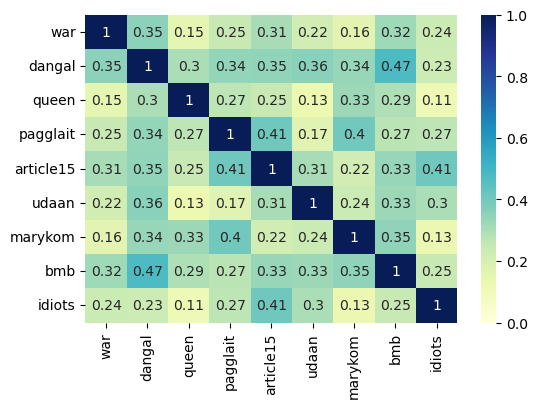

In [30]:
sbert_movies = { k: sbert.encode(v) for k, v in movies.items() }
compute_similarities_and_plot(sbert_movies, "sbert")


In [31]:
ada_movies = { k: get_embedding(v, embedding_model) for k, v in movies.items() }

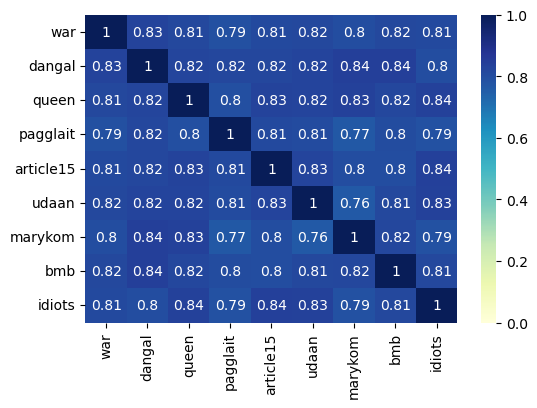

In [32]:
compute_similarities_and_plot(ada_movies, "ada")